In [1]:
import os
import sys
from pathlib import Path
import scanpy as sc
import scirpy as ir
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy


sys.path.insert(0, '/mnt/efs/hdiao/Projects/Tools')
import sc_tl

%matplotlib inline

sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 louvain==0.7.1 pynndescent==0.5.7


In [2]:
# Assign dimentionality reduction & clustering output to adata
def assign_DR_Clustering(adata, adata_DR_Clustering):
    adata.obsm = adata_DR_Clustering.obsm
    adata.uns['pca'] = adata_DR_Clustering.uns['pca']
    adata.uns['neighbors'] = adata_DR_Clustering.uns['neighbors']
    adata.uns['leiden'] = adata_DR_Clustering.uns['leiden']
    adata.uns['umap'] = adata_DR_Clustering.uns['umap']
    adata.obs['leiden'] = adata_DR_Clustering.obs['leiden']
    return adata

In [3]:
sp_name = "T"

###----- Setup output directories
wk_dir = "/mnt/efs/hdiao/Projects/BNT162b4_scRNA/1_scanpy_scirpy/1_%s"%sp_name
Path(wk_dir).mkdir(parents=True, exist_ok=True)

###----- Read feature reference and cite
sp_h5ad = "%s/%s_fltRS.h5ad"%(wk_dir, sp_name)

adata = sc.read_h5ad(sp_h5ad)

###----- Separate out GEX data
gene_list = adata.var[adata.var['feature_types'] == 'Gene Expression'].index.tolist()
gene_list_slt = [x for x in gene_list if "Trbv" not in x and "Trav" not in x] # Remove Tra Trb genes
cite_list = adata.var[adata.var['feature_types'] == 'Antibody Capture'].index.tolist()

adata_gex = adata[:, gene_list_slt]

## Dimentionality reduction and clustering

computing PCA
    with n_comps=50
    finished (0:00:00)


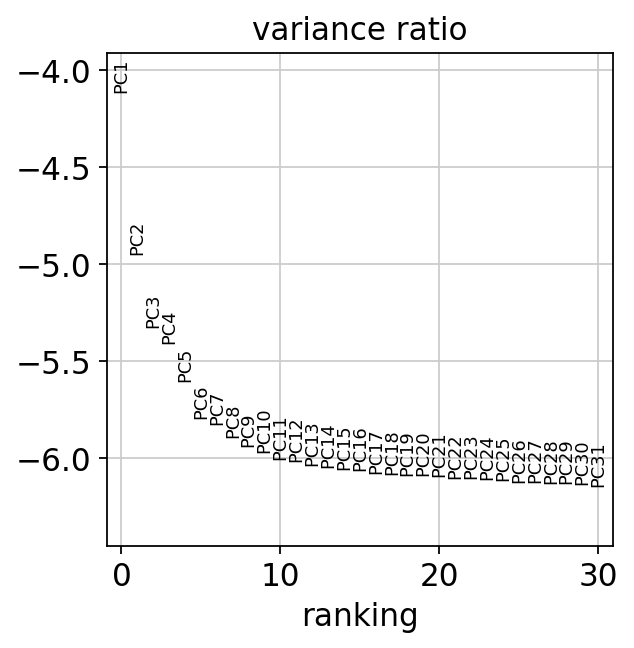

In [4]:
sc.tl.pca(adata_gex, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_gex, log=True)

In [5]:
sc.pp.neighbors(adata_gex, n_neighbors=100, n_pcs=14)
sc.tl.umap(adata_gex)
sc.tl.leiden(adata_gex)
adata_gex.obsp["connectivities"] = adata_gex.obsp["connectivities"].copy()

###----- Assign dimentionality reduction & clustering output to adata
adata = assign_DR_Clustering(adata, adata_gex)

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished (0:00:03)
computing UMAP
    finished (0:00:15)
running Leiden clustering
    finished (0:00:02)


## Plotting

/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/efs/hdiao/miniconda3/envs/scPy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


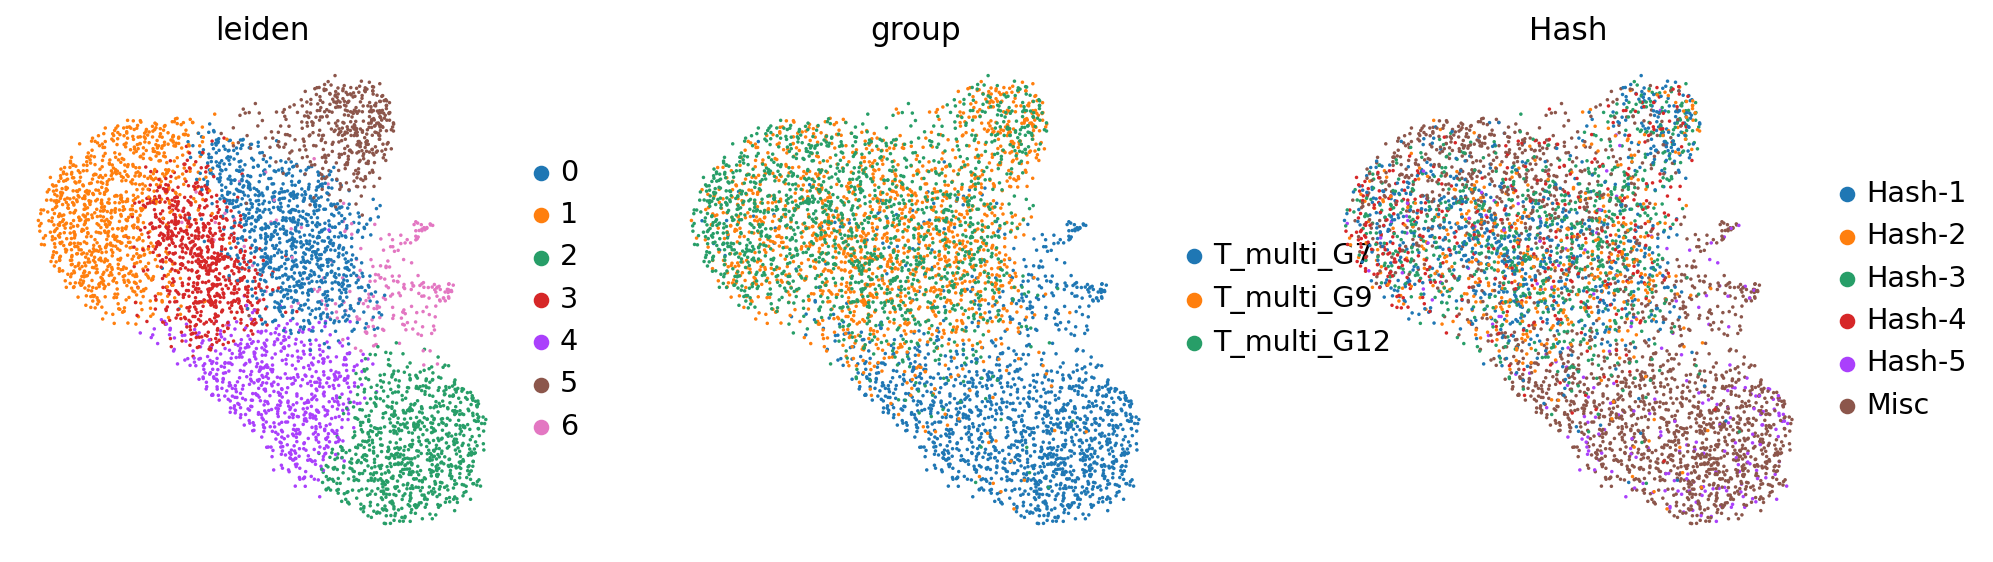

In [6]:
sc.pl.umap(adata, color=['leiden', 'group', 'Hash'], size=10)

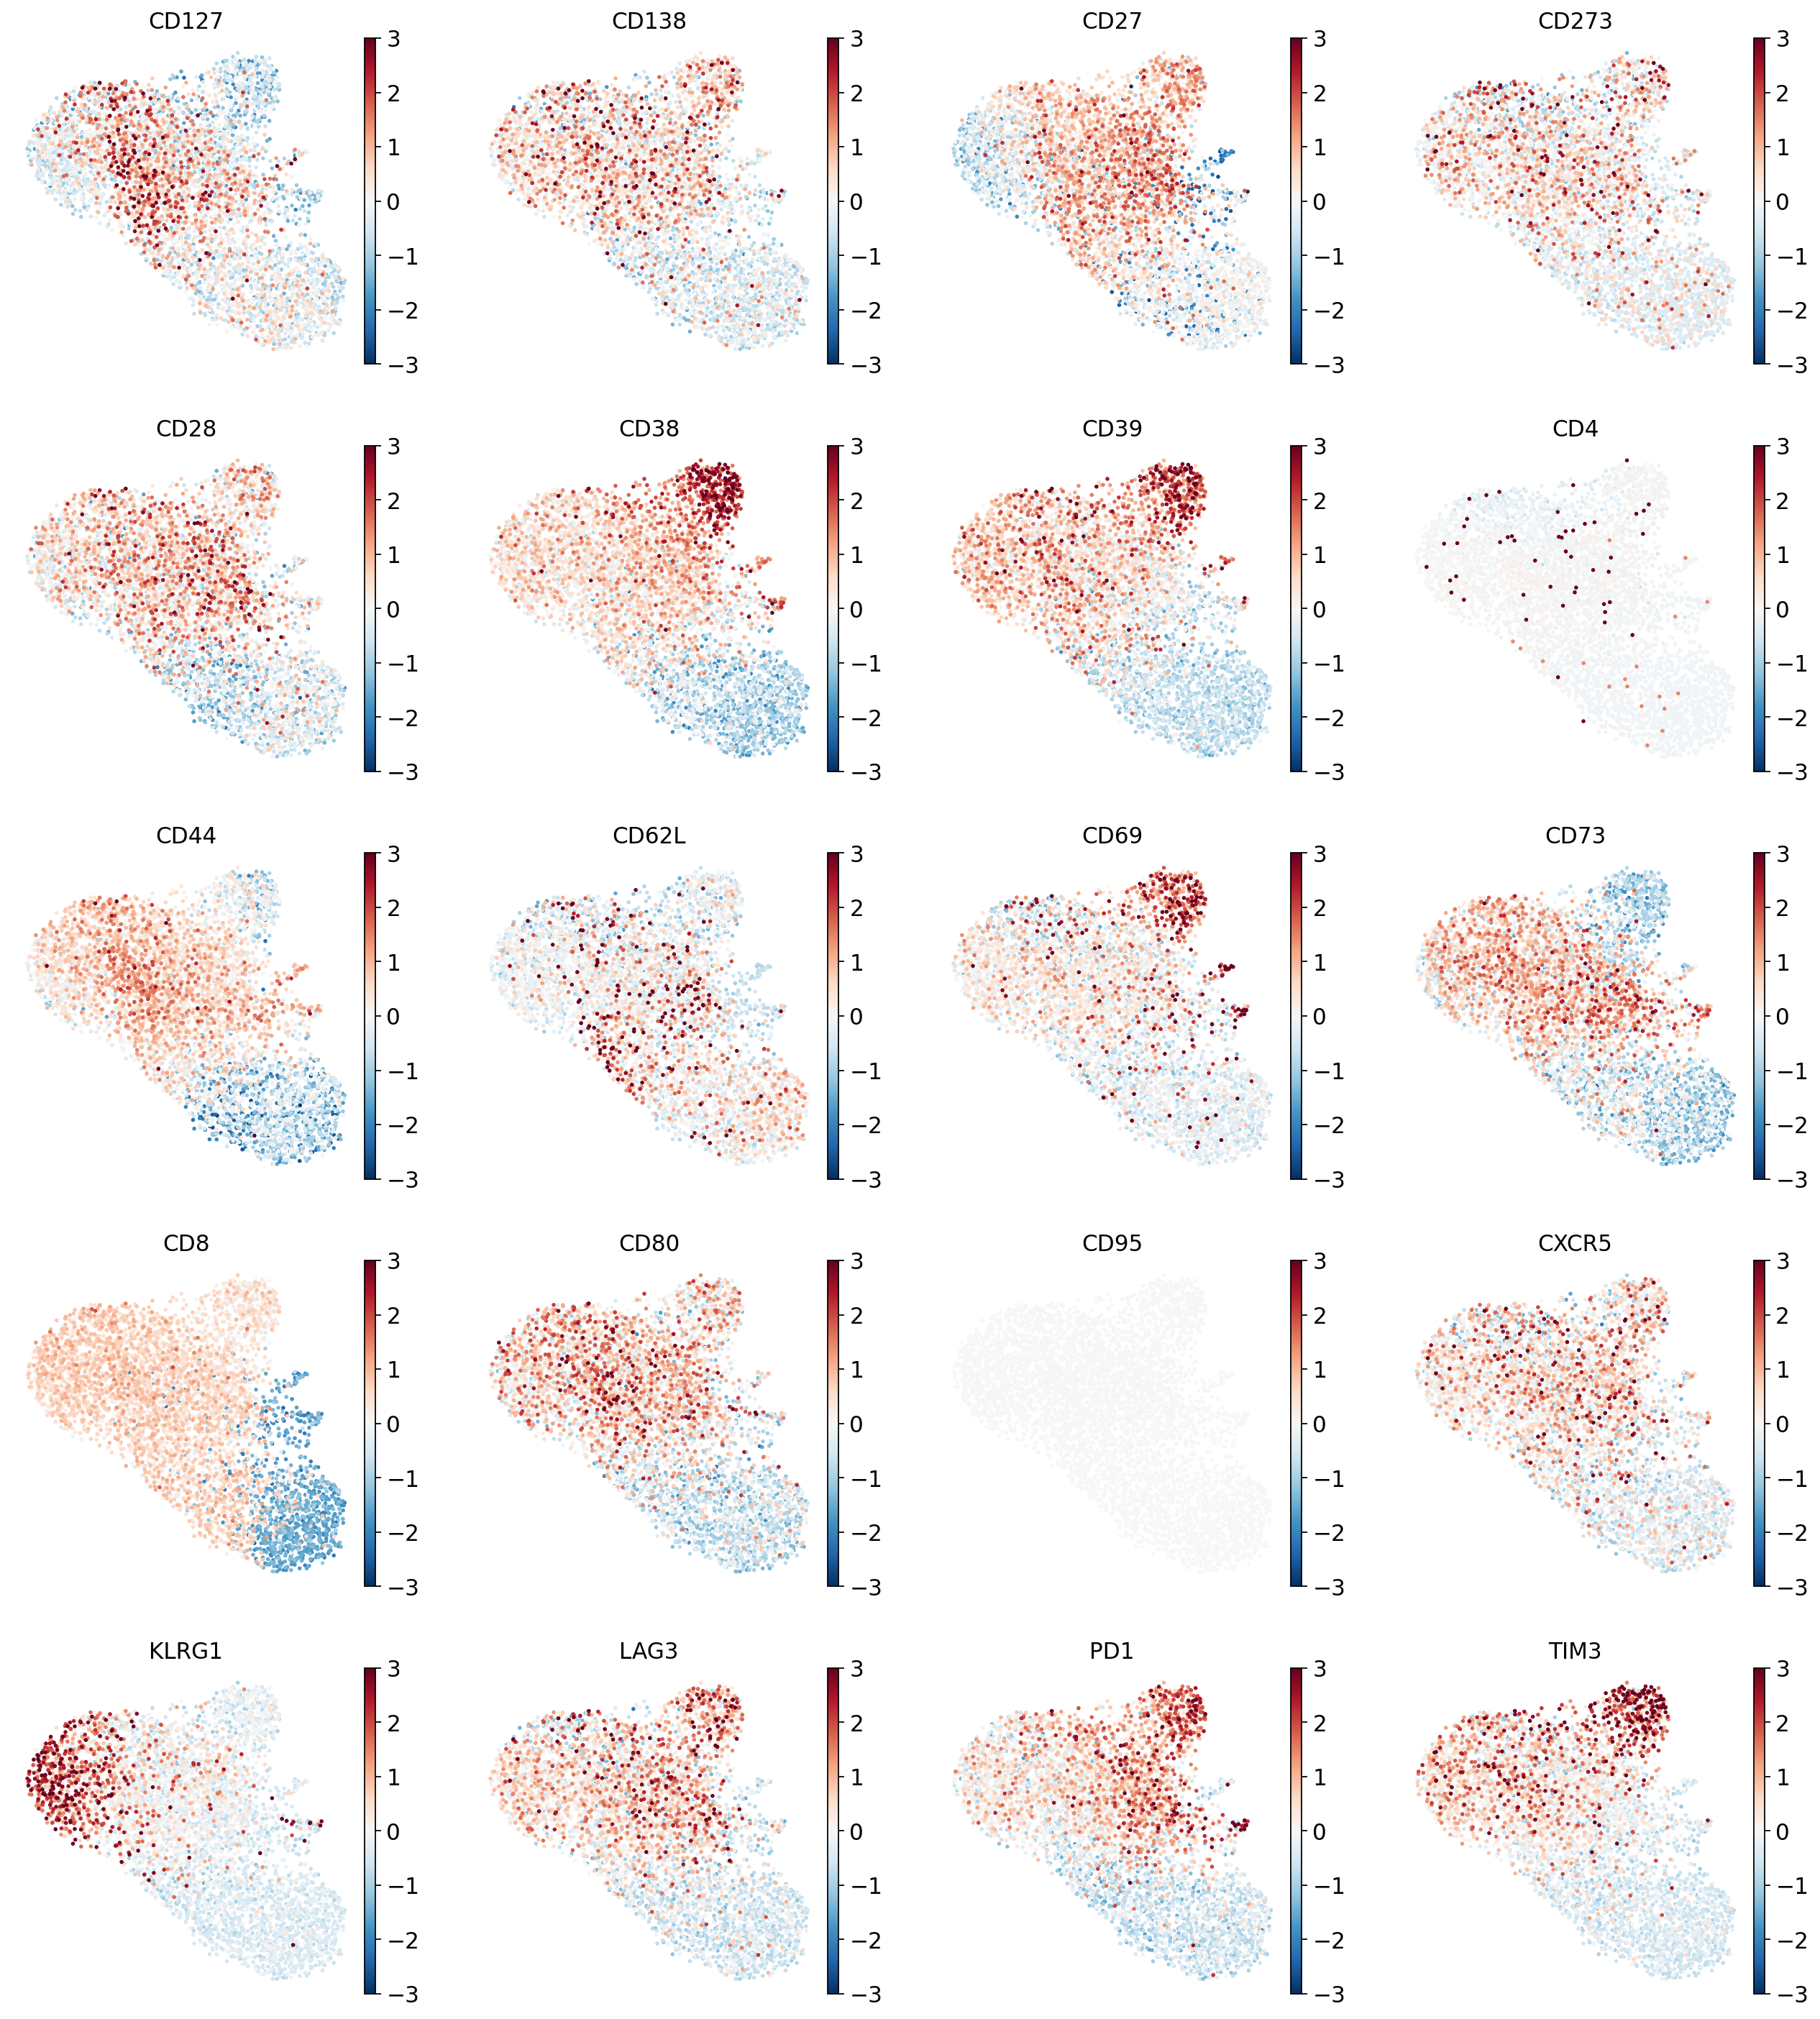

In [7]:
sc.pl.umap(adata, color=[x for x in cite_list if 'Hash' not in x], ncols=4 , vmin=-3, vmax=3, use_raw=False, cmap='RdBu_r')

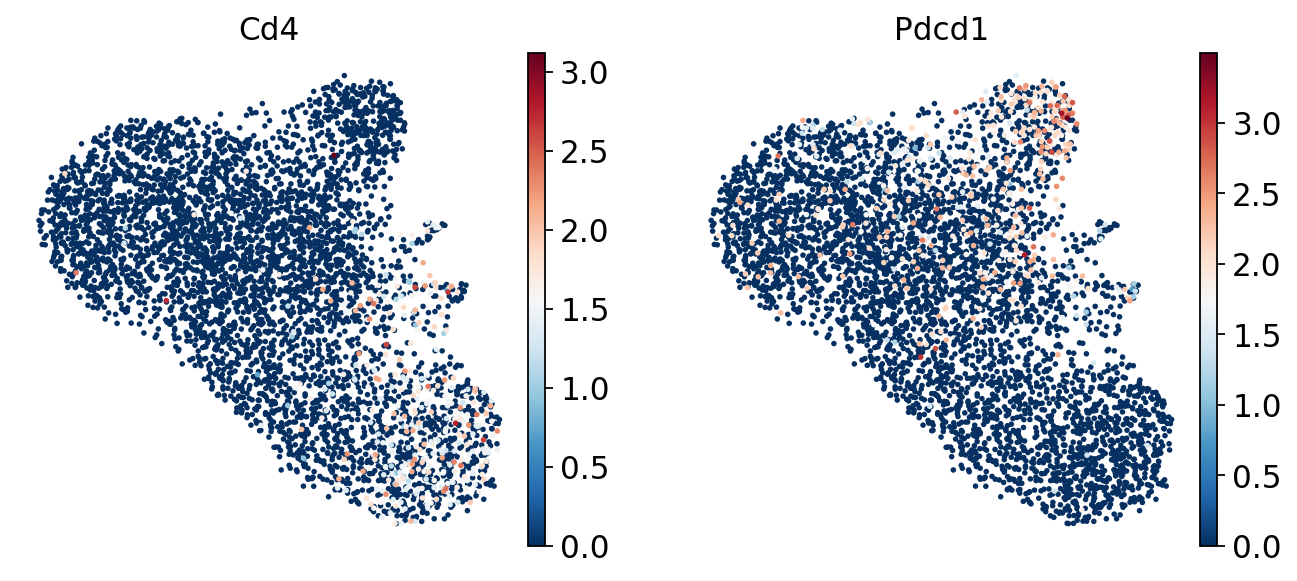

In [8]:
sc.pl.umap(adata, color=['Cd4', 'Pdcd1'], ncols=4 , cmap='RdBu_r')

## Save

In [9]:
out_name = "%s/%s_fltRS_leiden.h5ad"%(wk_dir, sp_name)

adata.write(out_name)